In [1]:
# ! apt-get install default-jre
# !java -version
# ! pip install h2o

import pandas as pd
import numpy as np
from google.colab import files, drive
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.metrics
import h2o
from h2o.estimators import H2ORandomForestEstimator

%env PYTHONHASHSEED=2022


env: PYTHONHASHSEED=2022


In [2]:
# uploaded = files.upload()

# Data Cleaning and Exploration

In [3]:
# load data
df = pd.read_csv("recruiting_zeta-disease_training-data_take-home-challenge - 2021_zeta-disease_training-data_take-home-challenge.csv")


In [4]:
df.describe()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,30.985000,172.407500,32.201625,69.565000,85.887500,0.544496,43.121250,4.051250,0.348750
std,13.824025,31.942438,8.549155,19.874784,126.333656,0.348711,30.409949,4.176173,0.476873
min,18.000000,94.000000,0.000000,0.000000,0.000000,0.140800,0.000000,0.000000,0.000000
25%,21.000000,149.000000,27.300000,62.000000,0.000000,0.307800,0.000000,1.000000,0.000000
50%,26.000000,167.000000,32.050000,72.000000,45.000000,0.445300,53.000000,3.000000,0.000000
75%,38.000000,192.000000,36.525000,80.000000,130.000000,0.699800,62.000000,6.000000,1.000000
max,109.000000,308.000000,86.100000,157.000000,1077.000000,3.481300,214.000000,40.000000,1.000000


In [5]:
df.zeta_disease.value_counts()

0    521
1    279
Name: zeta_disease, dtype: int64

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 <a list of 9 Text major ticklabel objects>)

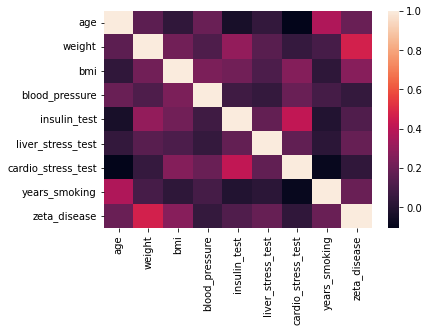

In [6]:
# correlation heatmap
cormat = df.corr()
round(cormat, 2)
ax = sns.heatmap(cormat, annot_kws={"fontsize": 200})
plt.xticks(fontsize=10,rotation=90)
plt.yticks(fontsize=10)


No handles with labels found to put in legend.


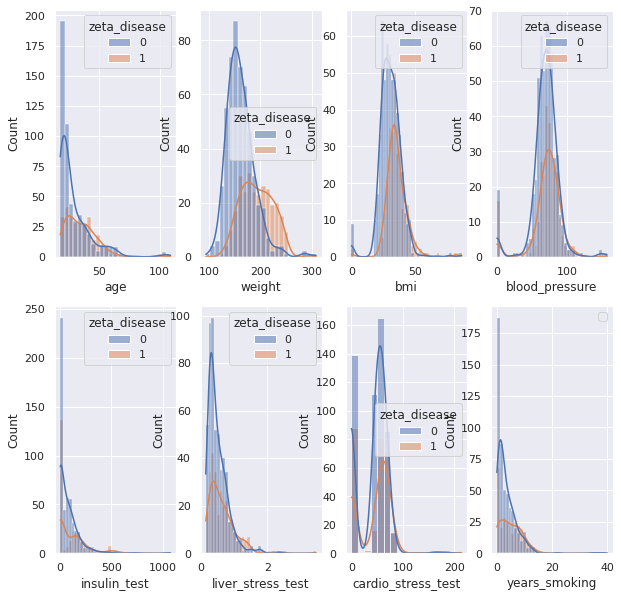

In [7]:
# distribution plot
sns.set(style="darkgrid")

fig, axs = plt.subplots(2, 4, figsize=(10, 10))

sns.histplot(data=df, x="age", hue="zeta_disease", kde=True, ax=axs[0, 0])
sns.histplot(data=df, x="weight", hue="zeta_disease", kde=True, ax=axs[0, 1])
sns.histplot(data=df, x="bmi", hue="zeta_disease", kde=True, ax=axs[0, 2])
sns.histplot(data=df, x="blood_pressure", hue="zeta_disease", kde=True, ax=axs[0, 3])
sns.histplot(data=df, x="insulin_test", hue="zeta_disease", kde=True, ax=axs[1, 0])
sns.histplot(data=df, x="liver_stress_test", hue="zeta_disease", kde=True, ax=axs[1, 1])
sns.histplot(data=df, x="cardio_stress_test", hue="zeta_disease", kde=True, ax=axs[1, 2])
sns.histplot(data=df, x="years_smoking", hue="zeta_disease", kde=True, ax=axs[1, 3])

plt.legend() 
plt.show()

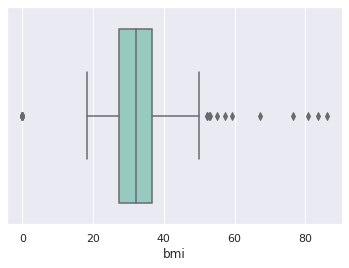

In [8]:
# bmi boxplot
ax = sns.boxplot(x="bmi", hue="zeta_disease", data=df, palette="Set3")

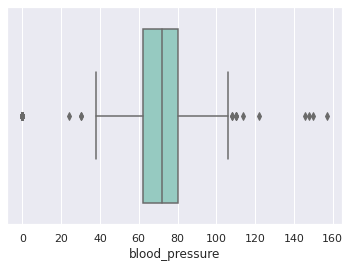

In [9]:
# blood_pressure boxplot
ax = sns.boxplot(x="blood_pressure", hue="zeta_disease", data=df, palette="Set3")

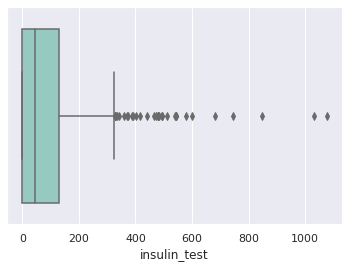

In [10]:
# insulin_test boxplot
ax = sns.boxplot(x="insulin_test", hue="zeta_disease", data=df, palette="Set3")

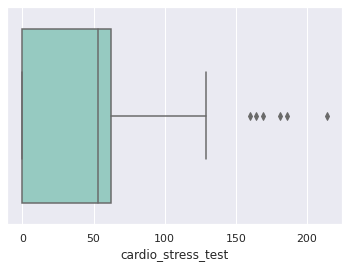

In [11]:
# cardio_stress_test boxplot
ax = sns.boxplot(x="cardio_stress_test", hue="zeta_disease", data=df, palette="Set3")

In [12]:
print(len(df[df.bmi==0])) # small number of missing values, no need for imputation
print(len(df[df.blood_pressure==0])) # small number of missing values, no need for imputation
print(len(df[df.insulin_test==0])) # need extra information to decide whether to impute missing value
print(len(df[df.cardio_stress_test==0])) # need extra information to decide whether to impute missing value

11
35
370
227


# Model Training

In [13]:
h2o.init()

df_h2o = h2o.H2OFrame(df)
df_h2o["zeta_disease"] = df_h2o["zeta_disease"].asfactor()
predictors = df_h2o.columns[:-1]
response = df_h2o.columns[-1]

# Split the dataset into a train and test set:
stratified_split = df_h2o[response].stratified_split(test_frac=0.3,seed=2022)
train = df_h2o[stratified_split=="train"]
test  = df_h2o[stratified_split=="test"]


Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.14" 2022-01-18; OpenJDK Runtime Environment (build 11.0.14+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.14+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpf6rjwaqc
  JVM stdout: /tmp/tmpf6rjwaqc/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpf6rjwaqc/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,06 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.3
H2O_cluster_version_age:,1 month and 5 days
H2O_cluster_name:,H2O_from_python_unknownUser_5slyyw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [14]:
print(train["zeta_disease"].table())
print(test["zeta_disease"].table())

zeta_disease,Count
0,365
1,195


zeta_disease,Count
0,156
1,84


In [15]:
# define training grid and perform random grid search
rf_params_h2o = {
    "ntrees": list(np.arange(30,70,5)),
    "mtries" : [round(np.sqrt(len(predictors)))],
    "max_depth" : list(np.arange(10,17,2)),
    "min_rows" : list(np.arange(2,7,2)),
    "stopping_metric" : ["AUTO"],
    "stopping_tolerance" : [0.005],
    "sample_rate" : list(np.arange(0.9,1.0,0.01)),
    "score_tree_interval" : [10],
    "nfolds" : [5]
}

grid = pd.DataFrame(sklearn.model_selection.ParameterGrid(rf_params_h2o))
grid = grid.sample(n=20, random_state=2022).reset_index(drop=True)

# model training 
model_list = list()
for i in range(len(grid)):
  grid_row = grid.iloc[i]

  model = H2ORandomForestEstimator(ntrees=int(grid_row["ntrees"]),
                                   mtries=int(grid_row["mtries"]),
                                   max_depth=int(grid_row["max_depth"]),
                                   min_rows=int(grid_row["min_rows"]),
                                   nfolds=int(grid_row["nfolds"]),
                                   sample_rate=grid_row["sample_rate"],
                                   seed=2022)
  model.train(x=predictors,
                y=response,
                training_frame=train)
  model_list.append(model)
model_auc = [model.auc(xval=True) for model in model_list]
best_model_idx = model_auc.index(max(model_auc))
best_model = model_list[best_model_idx]

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |███████████████████████

In [16]:
import math
round(np.sqrt(len(predictors))-1)

2

In [17]:
# ROC-AUC for both training and cross-validation set
best_model.auc(train=True, xval=True)

{'train': 0.776576302162656, 'xval': 0.8543097997892519}

In [18]:
# PR-AUC for both training and cross-validation set
best_model.aucpr(train=True, xval=True)

{'train': 0.6244240491159483, 'xval': 0.7421469098644757}

In [19]:
# Model Performance on test set
perf = best_model.model_performance(test)
print(perf)


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.18040952093871318
RMSE: 0.42474641957138753
LogLoss: 0.5533479480685867
Mean Per-Class Error: 0.2632783882783883
AUC: 0.7942612942612942
AUCPR: 0.642786652488801
Gini: 0.5885225885225884

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4388888865709305: 


,,0,1,Error,Rate
0,0,124.0,32.0,0.2051,(32.0/156.0)
1,1,27.0,57.0,0.3214,(27.0/84.0)
2,Total,151.0,89.0,0.2458,(59.0/240.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.438889,0.658960,82.0
1,max f2,0.097222,0.786290,148.0
2,max f0point5,0.725000,0.673077,39.0
3,max accuracy,0.725000,0.758333,39.0
4,max precision,0.972222,1.000000,0.0
5,max recall,0.016667,1.000000,190.0
6,max specificity,0.972222,1.000000,0.0
7,max absolute_mcc,0.461111,0.471845,80.0
8,max min_per_class_accuracy,0.302778,0.692308,100.0
9,max mean_per_class_accuracy,0.461111,0.737179,80.0



Gains/Lift Table: Avg response rate: 35.00 %, avg score: 34.42 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.012500,0.953389,2.857143,2.857143,1.000000,0.965741,1.000000,0.965741,0.035714,0.035714,185.714286,185.714286,0.035714
1,2,0.020833,0.942278,0.000000,1.714286,0.000000,0.947222,0.600000,0.958333,0.000000,0.035714,-100.000000,71.428571,0.022894
2,3,0.033333,0.924528,1.904762,1.785714,0.666667,0.936111,0.625000,0.950000,0.023810,0.059524,90.476190,78.571429,0.040293
3,4,0.041667,0.917889,1.428571,1.714286,0.500000,0.920833,0.600000,0.944167,0.011905,0.071429,42.857143,71.428571,0.045788
4,5,0.050000,0.911389,2.857143,1.904762,1.000000,0.916667,0.666667,0.939583,0.023810,0.095238,185.714286,90.476190,0.069597
5,6,0.100000,0.839722,1.904762,1.904762,0.666667,0.884028,0.666667,0.911806,0.095238,0.190476,90.476190,90.476190,0.139194
6,7,0.150000,0.778611,2.857143,2.222222,1.000000,0.802877,0.777778,0.875496,0.142857,0.333333,185.714286,122.222222,0.282051
7,8,0.200000,0.698333,1.904762,2.142857,0.666667,0.740046,0.750000,0.841634,0.095238,0.428571,90.476190,114.285714,0.351648
8,9,0.300000,0.546944,1.428571,1.904762,0.500000,0.635706,0.666667,0.772991,0.142857,0.571429,42.857143,90.476190,0.417582
9,10,0.400000,0.340556,1.071429,1.696429,0.375000,0.457986,0.593750,0.694240,0.107143,0.678571,7.142857,69.642857,0.428571


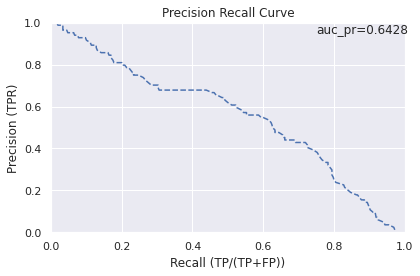

Best threshold for PR-Curve: 0.4388888865709305


In [20]:
# Plot Precision-Recall Curve
perf.plot(type="pr")
print(f"Best threshold for PR-Curve: {perf.find_threshold_by_max_metric('f1')}")

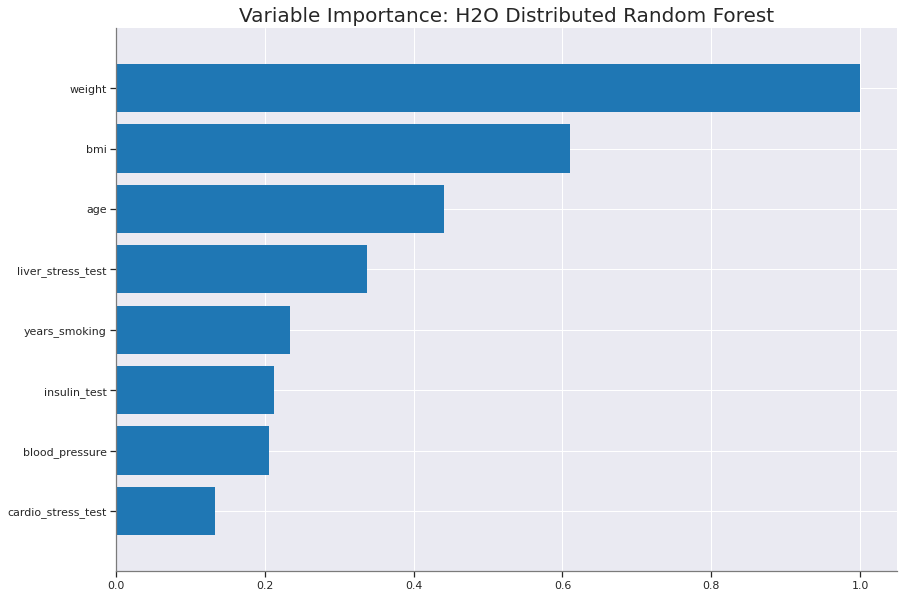

<Figure size 432x288 with 0 Axes>

In [21]:
# Variable Importance
best_model.varimp_plot()

# Model Inference

In [22]:
df_inf = pd.read_csv("recruiting_zeta-disease_prediction-data_take-home-challenge - 2021-01-21_zeta-disease_prediction-data_take-home-challenge.csv")

In [23]:
df_inf.head()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,24,151,39.5,69,72,1.3968,56,4,NaN
1,27,179,35.5,89,156,1.6608,43,6,NaN
2,34,147,26.9,76,74,1.6958,53,2,NaN
3,35,206,32.4,73,127,1.4608,61,6,NaN
4,60,193,29.8,62,192,1.7798,65,9,NaN


In [24]:
df_inf_h2o = h2o.H2OFrame(df_inf.drop(["zeta_disease"],axis=1))
prediction_inf = best_model.predict(df_inf_h2o).as_data_frame()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [25]:
threshold = perf.find_threshold_by_max_metric('f1')
prediction_inf["zeta_disease"] = prediction_inf.apply(lambda x: 1 if x["p1"] >= threshold else 0, axis=1)

In [26]:
df_inf["zeta_disease"] = prediction_inf["zeta_disease"]

In [27]:
drive.mount("/drive")
df_inf.to_csv("/drive/My Drive/Interviews/Pluralsight/predictions.csv",index=False)

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
